# Introduction to Simpy

[Simpy](https://simpy.readthedocs.io/en/latest/contents.html) is a Python library for the simulation of systems that interact through discrete events. There are two essential to using Simpy:

1. The simulation environment that manages the simulation.
2. Processes you create to model system behavior.

This notebook introduces these concepts using a toy example.

## Creating a simulation environment

A simulation environment is created with `simpy.Environment()`. The resulting object provides a collection of methods for setting and controlling a simulation.

In [91]:
import simpy

env = simpy.Environment()
print("time = ", env.now)
env.run()

time =  0


That's all it takes to create and run a simulation. But we didn't give the simulation anything to do, so there are no details to report.

## Creating simulation processes

System behavior is modeled as a system of Simpy processes. Processes are implemented with the Python `yield` statement, and attached to the simulation environment with `env.process()`.

A process communicates with the simulation environment through the `yield` statement. The yield statement sends an event back to the simulation environment. The the passage of time is modeled with `env.timeout(delay)` event.

In [96]:
import simpy

# a python generator
def print_msg():
    yield env.timeout(1.0)
    print("time =", env.now, ": Hello, World.")
    
# create a simulation environment
env = simpy.Environment()

# use a generator to create a simpy process
env.process(print_msg())

# run the simulation
env.run()

time = 1.0 : Hello, World.


The generator may include parameters to create unique instances. This is the foundation of "agent-based" modeling.

In [98]:
import simpy

# modify the generator to include parameters
def print_msg(delay, msg):
    yield env.timeout(delay)
    print(f"time {delay}: {msg}")

# create a simulation environment
env = simpy.Environment()

# create multiple, unique instances of the process model
env.process(print_msg(3.0, "Hello, World."))
env.process(print_msg(1.0, "Hello, Indiana."))
env.process(print_msg(2.0, "Hello, Notre Dame."))

# run the simulation
env.run()

time 1.0: Hello, Indiana.
time 2.0: Hello, Notre Dame.
time 3.0: Hello, World.


Note that the simulation environment correctly orders the events! 

## Events

Simpy includes many different event types that are managed by the simulation environment. The `env.timeout(delay)` demonstrated above is a mainstay in Simpy models. Many applications require nothing more.

In [103]:
import simpy

# modify the generator to include parameters
def print_msg(delay, msg):
    yield env.timeout(delay)
    print(f"time {delay}: {msg}")
    
# print message when a list of processes have completed
def final_msg(msg, list_of_processes):
    yield simpy.AllOf(env, list_of_processes)
    print(env.now, msg)

# create a simulation environment
env = simpy.Environment()

# create multiple, unique instances of the process model
a = env.process(print_msg(3.0, "Hello, World."))
b = env.process(print_msg(1.0, "Hello, Indiana."))
c = env.process(print_msg(2.0, "Hello, Notre Dame."))

env.process(final_msg("All done", [a, b, c]))

# run the simulation
env.run()

time 1.0: Hello, Indiana.
time 2.0: Hello, Notre Dame.
time 3.0: Hello, World.
3.0 All done


What we observe is that the simulation environment is scheduling tasks and executng them in a time ordered sequence, not the order in which they are created.

<hr>

**Study Question:** Use `simpy.AnyOf(env, events)` to produce a message when the first process has completed.

<hr>

## Ready to Roomba

In [79]:
import simpy

def roomba(name):
    print(f"{env.now:3d}: {name} starts cleaning.")
    yield env.timeout(20)
    print(f"{env.now:3d}: {name} battery dies.")
        
env = simpy.Environment()
env.process(roomba("A"))
env.run()

  0: A starts cleaning.
 20: A battery dies.


 35: 0 start charging.
 40: 0 finished charging.
 40: 1 start charging.
 45: 1 finished charging.
 45: 2 start charging.
 50: 2 finished charging.
 50: 3 start charging.
 55: 3 finished charging.
 55: 4 start charging.
 60: 4 finished charging.
 60: 5 start charging.
 65: 5 finished charging.
 65: 6 start charging.
 70: 6 finished charging.
 70: 7 start charging.
 75: 7 finished charging.
 75: 8 start charging.
 80: 8 finished charging.
 80: 9 start charging.
 85: 9 finished charging.
 85: 10 start charging.
 90: 10 finished charging.
 90: 11 start charging.
 95: 11 finished charging.
 95: 12 start charging.
100: 12 finished charging.
100: 13 start charging.
105: 13 finished charging.
105: 14 start charging.
110: 14 finished charging.
110: 15 start charging.
115: 15 finished charging.
115: 16 start charging.
120: 16 finished charging.
120: 17 start charging.
125: 17 finished charging.
125: 18 start charging.
130: 18 finished charging.
130: 19 start charging.
135: 19 finished charging.


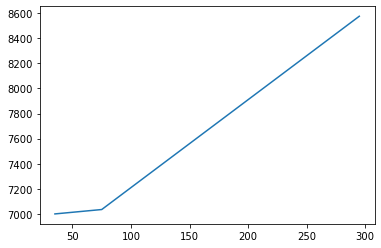

In [102]:
import simpy
import matplotlib.pyplot as plt

total_cleaning_time =  0
cleaning = {}

def roomba(name, battery):
    global cleaning, total_cleaning_time
    while True:
        start = env.now
        #print(f"{start:3d}: {name} starts cleaning.")
        yield env.timeout(battery)
        
        stop = env.now
        #print(f"{stop:3d}: {name} stops cleaning.")
        total_cleaning_time = total_cleaning_time + stop - start
        cleaning[env.now] = total_cleaning_time
        
        request = charger.request()
        yield request
        
        print(f"{env.now:3d}: {name} start charging.")
        yield env.timeout(5)
        print(f"{env.now:3d}: {name} finished charging.")
        
        charger.release(request)
        
env = simpy.Environment()
charger = simpy.Resource(env, capacity=1)
for n in range(200):
    env.process(roomba(n, 35))
env.run(until=300)

print(cleaning)
plt.plot(cleaning.keys(), cleaning.values())

## Chemotaxis

In [88]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import simpy

track = {}
x_max = 10.0
y_max = 10.0
dt = 2
v = 0.2

# concentration gradient
def c(x, y):
    return 0.01*x  +  0.10

# agent model
def agent(n, x, y):
    track[n] = {(x, y)}
    s = 0
    a = np.random.uniform(0, 2*np.pi)
    vx, vy = v*np.cos(a), v*np.sin(a)
    while True:
        yield env.timeout(dt)
        dx = vx*dt
        dy = vy*dt
        x += dx
        y += dy
        log[n][env.now] = (x, y)
        p = np.random.uniform()
        if p <= 1.0*c(x,y)/(1 + c(x,y)):
            s = 0
        else:
            s += np.sqrt(dx**2 + dy**2)
        if s >= 2.0:
            s = 0
            a = np.random.uniform(0, 2*np.pi)
            vx, vy = v*np.cos(a), v*np.sin(a)
    
env = simpy.Environment()
for n in range(1000):
    env.process(agent(n, np.random.uniform(0, x_max), np.random.uniform(0, y_max)))
env.run(until=1000)

(-50.40269074821132,
 172.2475489109109,
 -102.09903103792954,
 120.55120862119267)

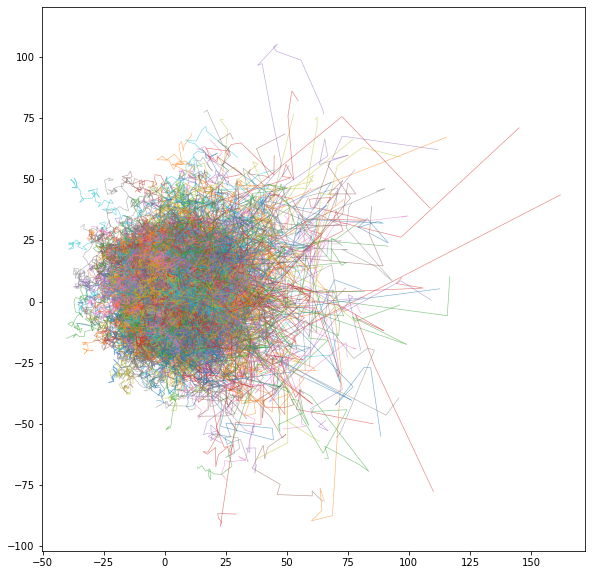

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for n in log.keys():
    pos = log[n].values()
    ax.plot([x for x,y in pos], [y for x,y in pos], lw=0.6, alpha=0.6)
    
ax.axis('equal')
ax.axis('square')

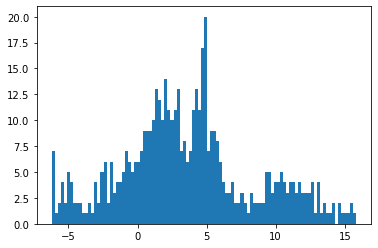

In [90]:
plt.hist([x for x,y in pos], bins = 100);